In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import scipy.stats as ss
import math

# Question formulation 
### Assume you have USD100,000. You are looking at trading Coke and Pepsi. Assume cash earns 5% per year in the bank.

### On the 9th of October 2023, at the close of the market, assume you short sell USD100,000 shares of Coke stock, use the proceeds to buy USD100,000 shares of Pepsi.
### Simulate 1,000,000 daily paths of the pairs trade for the next 3 months (60 trading days). Be explicit with all the assumptions you make on the random walks you generate and how you think about their correlation and mean-reversion.
### If we enter the trade on the 9th what is the expected value of the trade on the 16th? What is the 5th and 95th percentile profit-loss? At what price differential would you enter this pairs trade, at what price would you exit? Why?


# Data
As of 4th October 2023, the closing price of Coke is USD 55.10, Implied volatility 18.75%, Dividend yield 3.29%, 
As of 4th October 2023, the closing price of Pepsi is USD 167.98, Implied volatility 22.00%, Dividend yield 2.85%, 
we use past 10 years data to work out the correlation between the two stocks are 0.73

In [127]:
ticker = ['KO', 'PEP']
historical_data = yf.download(ticker, start='2013-10-04', end='2023-10-04')

[*********************100%%**********************]  2 of 2 completed


<Axes: xlabel='Date'>

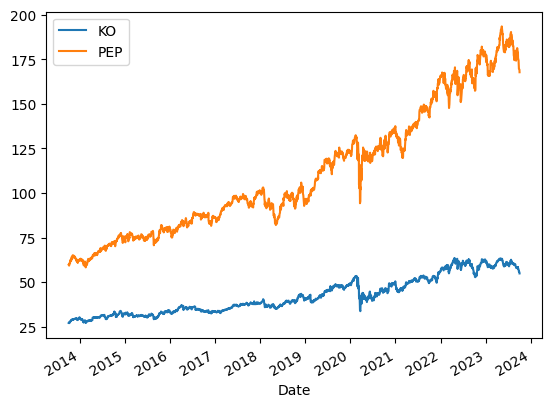

In [128]:
historical_data = historical_data.loc[:, 'Adj Close']
historical_data.plot()

In [129]:
corr_mat = (historical_data.pct_change().corr())
corr_mat

,KO,PEP
KO,1.00000,0.73668
PEP,0.73668,1.00000


# Monte Carlo Simulation forecast

In [130]:
np.random.seed(1)

In [131]:
S0_ko = historical_data.iloc[-1,0]# using the last value
S0_pep = historical_data.iloc[-1,1]# using the last value
# sigma_ko = historical_data['KO'].pct_change().std()# using historical volatility
# sigma_pep = historical_data['PEP'].pct_change().std()# using historical volatility
# mu_ko = historical_data['KO'].pct_change().mean()# using historical average daily return
# mu_pep = historical_data['PEP'].pct_change().mean()# using historical average daily return

In [132]:
mu_ko = 0.0329
mu_pep = 0.0285
sigma_ko = 0.1875
sigma_pep = 0.22

In [180]:
T=1
NTrials = 1_000_000
# NTrials = 10000
# daily experiment
NSteps = 252
dt = T/NSteps
t = np.linspace(0,T,NSteps)

In [134]:
# we are only looking for 60 trading days
U_ko = np.random.uniform(size=(NTrials, 60))
U_pep = np.random.uniform(size=(NTrials, 60))
dW_ko = ss.norm.ppf(U_ko)
dW_pep = ss.norm.ppf(U_pep)

In [135]:
L = np.linalg.cholesky(corr_mat)

In [136]:
for i in range(NTrials):
    temp = np.stack([dW_ko[i],dW_pep[i]]).T @ L.T
    dW_ko[i],dW_pep[i] = temp[:,0],temp[:,1]

In [137]:
# confirm the correlation between two random number is 0.73
pd.DataFrame([dW_ko.reshape(-1)[:1000],dW_pep.reshape(-1)[:1000]]).T.corr()

,0,1
0,1.000000,0.724837
1,0.724837,1.000000


In [138]:
# simulate the stock price using Geometric Brownian Motion
dS_ko = mu_ko * dt + sigma_ko * dW_ko * np.sqrt(dt)
dS_pep = mu_pep * dt + sigma_pep * dW_pep * np.sqrt(dt)
S_ko = S0_ko * np.cumprod(1+dS_ko, axis=1)
S_pep = S0_pep * np.cumprod(1+dS_pep, axis=1)

In [139]:
# # simulate the stock price using Arithmetic Brownian Motion
# dS_ko = mu_ko *dt+ sigma_ko * dW_ko 
# dS_pep = mu_pep *dt+ sigma_pep * dW_pep
# S_ko = S0_ko + np.cumsum(dS_ko, axis=1)
# S_pep = S0_pep + np.cumsum(dS_pep, axis=1)

In [140]:
def plot_simulations(arr,name,extra_plot=True):
    plt.figure(figsize=(20,4))
    if extra_plot:
        plt.subplot(1,3,1)
        for sim in arr[:1000]:
            plt.plot(sim)
        plt.title(f'price simulation for {name}')
        plt.subplot(1,3,2)
        plt.plot(np.mean(arr,axis=0))
        plt.title(f'mean price simulation for {name}')
        plt.subplot(1,3,3)
        plt.plot(np.std(arr,axis=0))
        plt.title(f'std price simulation for {name}')
        plt.show()
    else:
        for sim in arr:
            plt.plot(sim)
        plt.title(f'price simulation for {name}')
        plt.show()

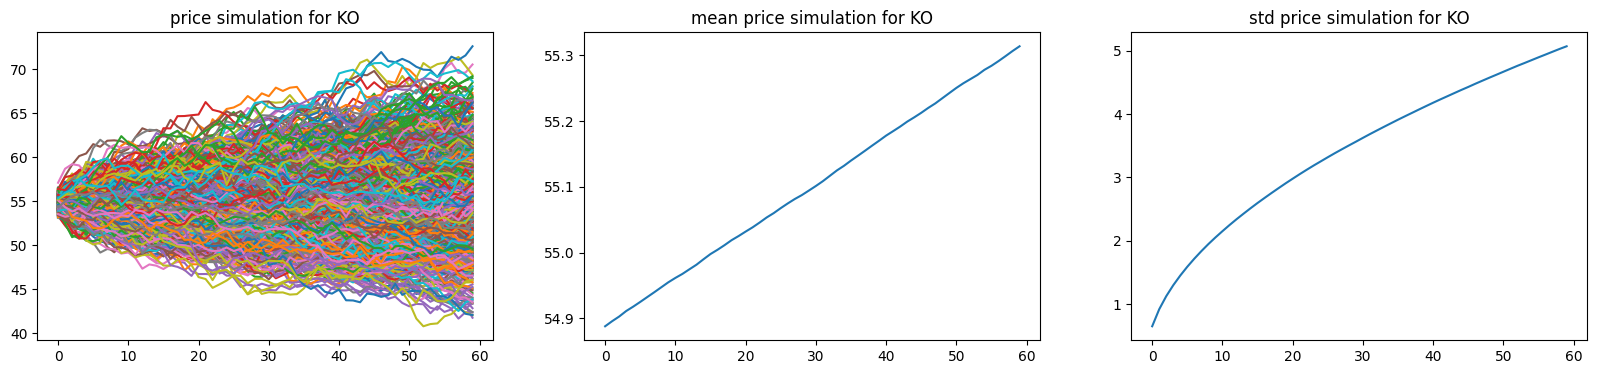

In [141]:
plot_simulations(S_ko,'KO')

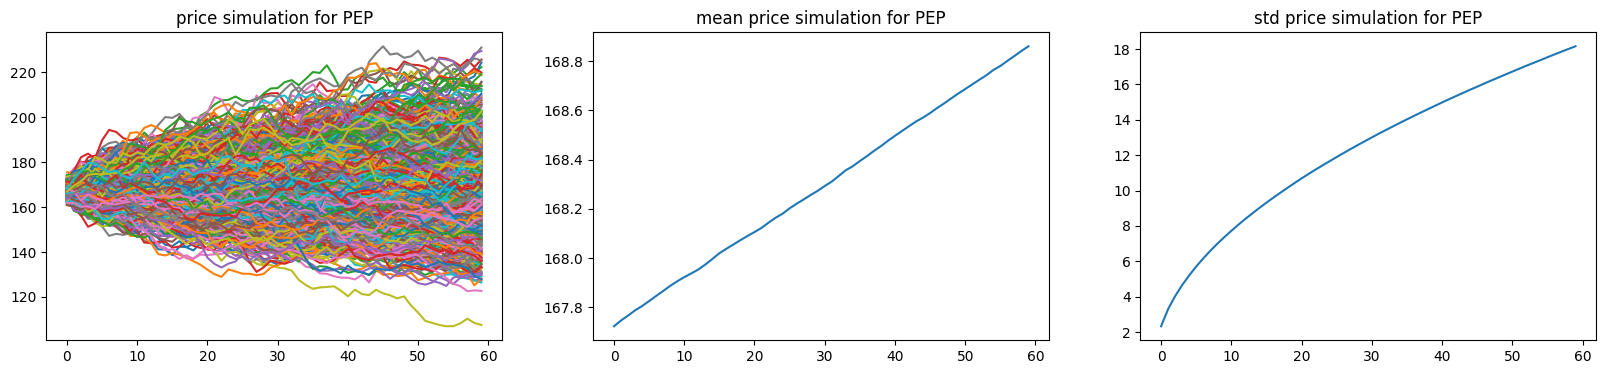

In [142]:
plot_simulations(S_pep,'PEP')

In [143]:
spread = S_pep-S_ko

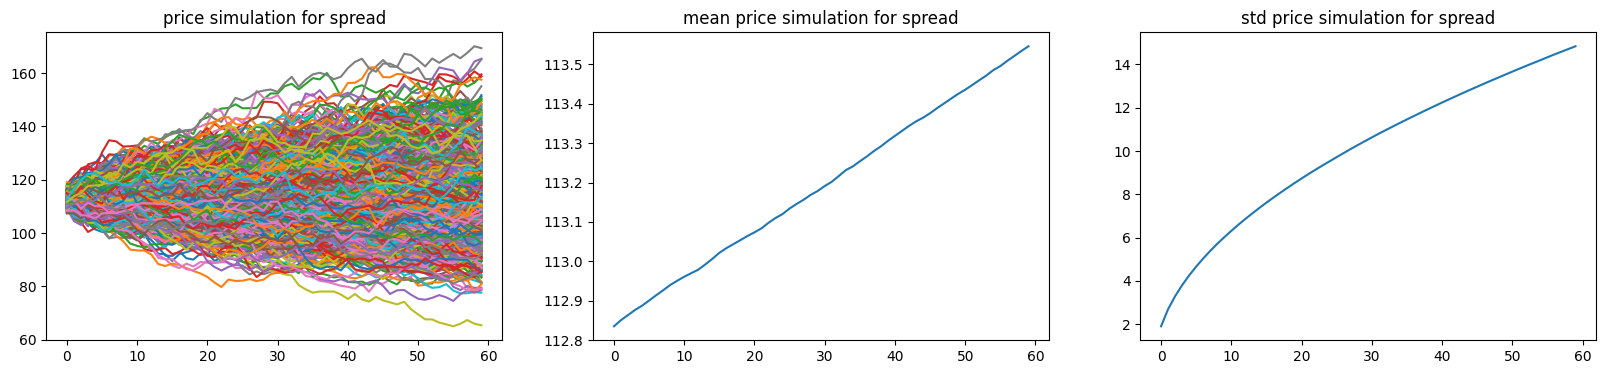

In [144]:
plot_simulations(spread,'spread')

In [145]:
historical_spread = historical_data['PEP']-historical_data['KO']

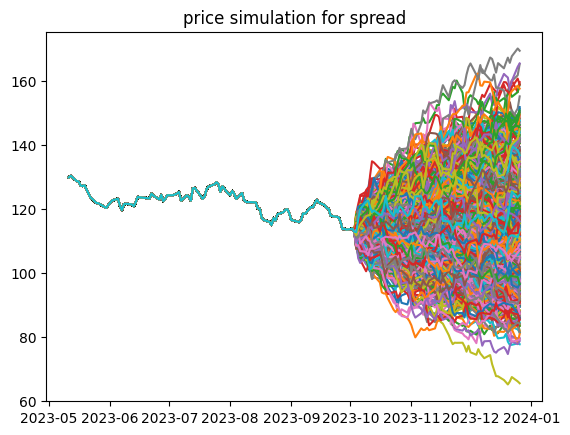

In [146]:
for sim in spread[:1000]:
    temp = pd.concat([historical_spread[-100:],pd.Series(sim,index=pd.bdate_range('2023-10-04',periods=60))])
    plt.plot(temp)
plt.title('price simulation for spread')
plt.show()

Text(0.5, 1.0, 'Confidence Interval for spread')

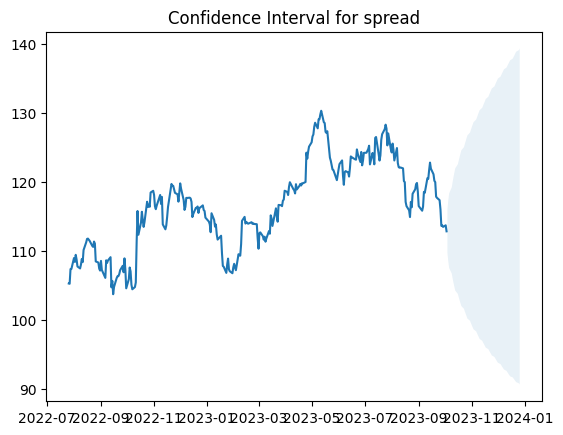

In [147]:
# Plot the Confidence interval for the spread:
plt.plot(historical_spread[-300:])
# plt.plot(historical_spread)
plt.fill_between(pd.bdate_range('2023-10-04',periods=60),np.quantile(spread,0.05,axis=0),np.quantile(spread,0.95,axis=0),alpha=0.1)
plt.title('Confidence Interval for spread')

# If we enter the trade on the 9th what is the expected value of the trade on the 16th?

### Assumptions: 
### 1. Assume no transaction cost, slippage, it is not hard for us to short coke, we trade on the close price of 9th October
### 2. Assume we can only buy stocks 100 shares at a time, and we can only short stocks 100 shares at a time

In [148]:
num_short_pep = math.floor((100_000/S0_pep)/100)*100
short_capital_gain = S0_pep*num_short_pep
num_long_ko = math.floor((short_capital_gain/S0_ko)/100)*100

In [149]:
print(f'number of PEP shares we short sell: {num_short_pep}')
print(f'amount of capital we have in short position: {num_short_pep*S0_pep}')
print(f'number of KO shares we long buy: {num_long_ko}')
print(f'amount of capital we have in long position: {num_long_ko*S0_ko}')
cash_reserve = num_short_pep*S0_pep-num_long_ko*S0_ko
print(f'cash reserve: {cash_reserve}')
long_pos = num_long_ko*S0_ko/(num_long_ko*S0_ko+num_short_pep*S0_pep)
short_pos = num_short_pep*S0_pep/(num_long_ko*S0_ko+num_short_pep*S0_pep)
print(f'percentage of capital we have in short pepsi position: {round(long_pos*100,2)}%')
print(f'percentage of capital we have in long coke position: {round(short_pos*100,2)}%')

number of PEP shares we short sell: 500
amount of capital we have in short position: 83849.9984741211
number of KO shares we long buy: 1500
amount of capital we have in long position: 82320.00160217285
cash reserve: 1529.9968719482422
percentage of capital we have in short pepsi position: 49.54%
percentage of capital we have in long coke position: 50.46%


### Initial position
at October 9th,
we have long coke position: 1500 stock
we have short pepsi position: 500 stocks
cash reserve: 1529.9 dollar 

In [150]:
long_pos * np.cumprod(1+dS_ko, axis=1)-short_pos * np.cumprod(1+dS_pep, axis=1)

array([[-0.00378309, -0.0090511 , -0.01359764, ...,  0.00358548,
         0.00595055,  0.00890938],
       [-0.01529887, -0.01314338, -0.01926131, ..., -0.02112625,
        -0.02155741, -0.02309031],
       [-0.01143363, -0.01412058, -0.0119844 , ..., -0.06547537,
        -0.0632205 , -0.06954749],
       ...,
       [-0.00990819, -0.01450165, -0.01226067, ...,  0.01654492,
         0.01342803,  0.01254753],
       [-0.00530535, -0.00352426, -0.00621093, ...,  0.01945967,
         0.01668526,  0.007305  ],
       [-0.00539345, -0.01271306, -0.01922572, ..., -0.04398921,
        -0.03873411, -0.03437889]])

In [151]:
position_return = long_pos * np.cumprod(1+dS_ko, axis=1)-short_pos * np.cumprod(1+dS_pep, axis=1)

In [152]:
position_value = num_long_ko*S_ko-num_short_pep*S_pep+cash_reserve

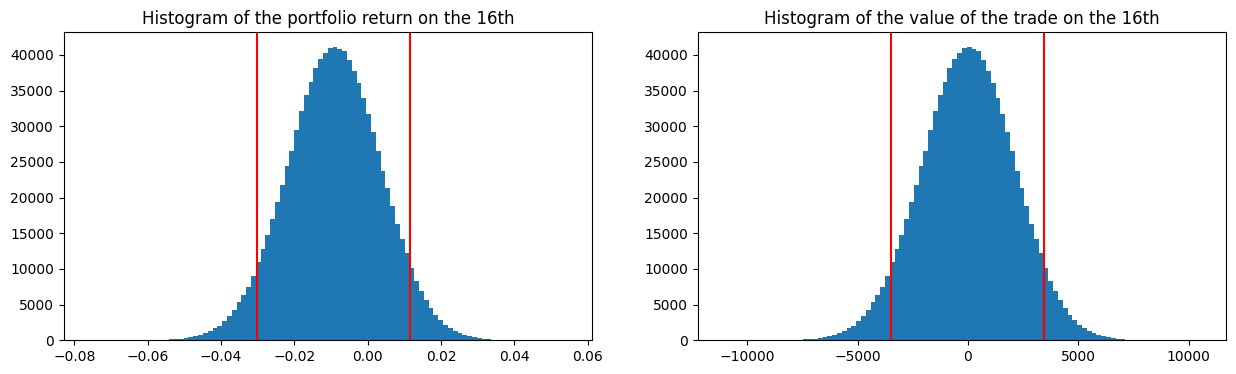

In [153]:
# the expected value of the trade on the 16th
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.hist(position_return[:,6],bins=100)
plt.title('Histogram of the portfolio return on the 16th')
plt.axvline(np.quantile(position_return[:,6],0.05),color='r')
plt.axvline(np.quantile(position_return[:,6],0.95),color='r')
plt.subplot(1,2,2)
plt.hist(position_value[:,6],bins=100)
plt.title('Histogram of the value of the trade on the 16th')
plt.axvline(np.quantile(position_value[:,6],0.05),color='r')
plt.axvline(np.quantile(position_value[:,6],0.95),color='r')

In [154]:
print(f'Expected value of the trade on the 16th: {np.mean(position_value[:,6])}')
print(f'95th percentile profit-loss: {round(np.quantile(position_return[:,6],0.95)*100,3)}%')
print(f'5th percentile profit-loss: {round(np.quantile(position_return[:,6],0.05)*100,3)}%')

Expected value of the trade on the 16th: 5.554752492236509
95th percentile profit-loss: 1.15%
5th percentile profit-loss: -3.015%


# Answer for Position timing:
### It is basically a mean-reversion trade: if we observe the spread > 95th percentile spread, it is equivalent of saying we have a view that pepsi is too high relative to coke, we should short pepsi and long coke until the spread goes back to 95th percentile.
### If we observe the spread < 5th percentile spread, it is equivalent of saying we have a view that pepsi is too low relative to coke, we should long pepsi and short coke until the spread goes back to 5th percentile.
# Pair Trading Strategy Simulation:
let's assume for simplicity that we can enter the trade perfectly (i.e. we can long pepsi, short coke and net 0 portfolio values). we would enter the trade as described above.
## Trading Timing Assumptions:
we assume that at t=0, if we observe the spread move out of the 5% 95% bound, we enter the trade
that means we don't trade t=0, and t=-1 (we don't know the spread return of t=-1)
so we calculate pct change of spread,then drop the first column
calculate trade direction, drop the last column 
*** to simplify, we don't have transaction cost for portfolio rebalancing. 

In [155]:
short_spread = spread>np.quantile(spread,0.95,axis=0)
long_spread = spread<np.quantile(spread,0.05,axis=0)
short_spread = -short_spread.astype(int)
long_spread = long_spread.astype(int)
pos_direction = short_spread+long_spread
pos_direction = pos_direction[:,:-1]

In [156]:
spread_ret = pd.DataFrame(spread).pct_change(axis=1).dropna(axis=1).values

In [157]:
strat_ret = np.cumprod(1+(pos_direction*spread_ret),axis=1)

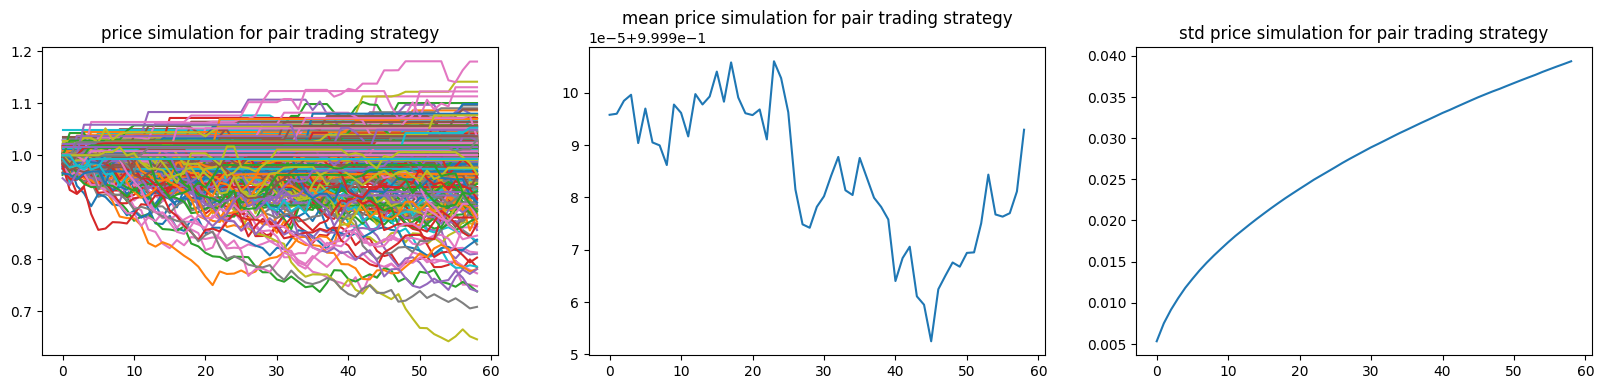

In [158]:
plot_simulations(strat_ret,'pair trading strategy')

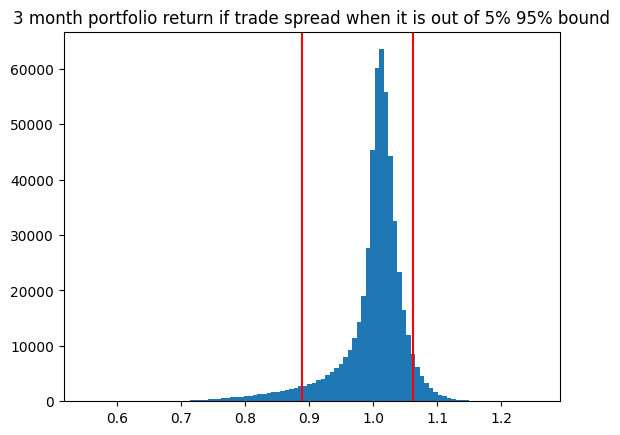

In [159]:
plt.hist(strat_ret[:,-1][np.where(strat_ret[:,-1]!=1)],bins=100)
plt.axvline(np.quantile(strat_ret[:,-1][np.where(strat_ret[:,-1]!=1)],0.05),color='r')
plt.axvline(np.quantile(strat_ret[:,-1][np.where(strat_ret[:,-1]!=1)],0.95),color='r')
plt.title('3 month portfolio return if trade spread when it is out of 5% 95% bound')
plt.show()

In [160]:
print(f'Expected value of the trade on the 16th: {np.mean(strat_ret[:,-1])}')

Expected value of the trade on the 16th: 0.999992906902878


# Extra: Simulating the spread using Ornstein-Uhlenbeck process

<Axes: xlabel='Date'>

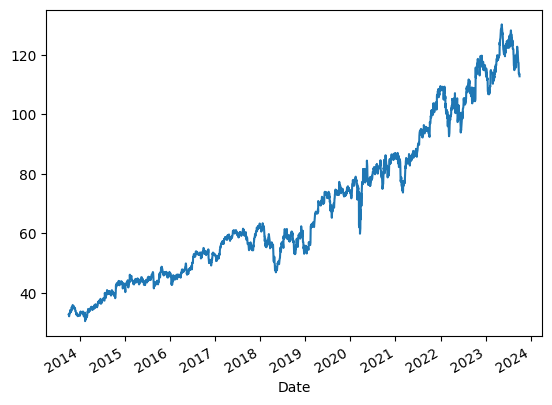

In [161]:
historical_spread.plot()

In [162]:
sTrend = historical_spread[0]+historical_spread.mean()*np.linspace(0,1,len(historical_spread))

Text(0.5, 1.0, 'spread minus trend')

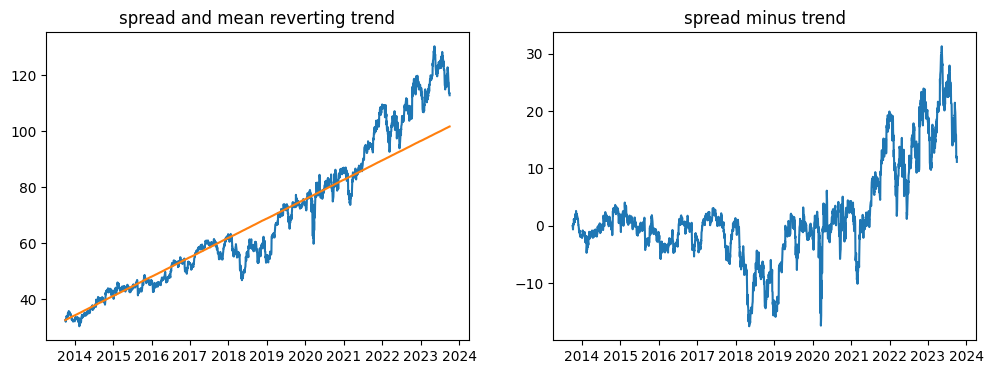

In [163]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(historical_spread)
plt.plot(pd.DataFrame(sTrend,index=historical_spread.index))
plt.title('spread and mean reverting trend')
plt.subplot(1,2,2)
plt.plot(historical_spread-sTrend)
plt.title('spread minus trend')

C:\Users\kevin\AppData\Local\Temp\ipykernel_11812\3965534735.py:5: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(range(len(acf)), acf, use_line_collection=True)


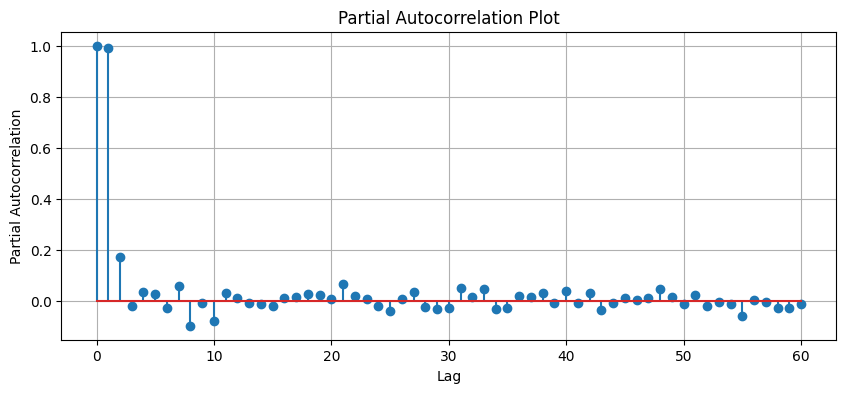

In [164]:
# partial autocorrelation plot
import statsmodels.api as sm
acf = sm.tsa.pacf(historical_spread-sTrend,nlags=60)
plt.figure(figsize=(10, 4))
plt.stem(range(len(acf)), acf, use_line_collection=True)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Plot')
plt.grid()
plt.show()

In [165]:
mu =(historical_spread-sTrend).mean()
sigma = (historical_spread-sTrend).std()

In [166]:
U = np.random.uniform(size=(10000, len(historical_spread)))
dW = ss.norm.ppf(U)
XOU = np.zeros(U.shape)
XOU[:,0] = 0

In [167]:
a = 0.005

In [168]:
for i in range(1,len(historical_spread)):
    XOU[:,i] = XOU[:,i-1] + a*(mu-XOU[:,i-1])*dt + sigma*dW[:,i]*np.sqrt(dt)

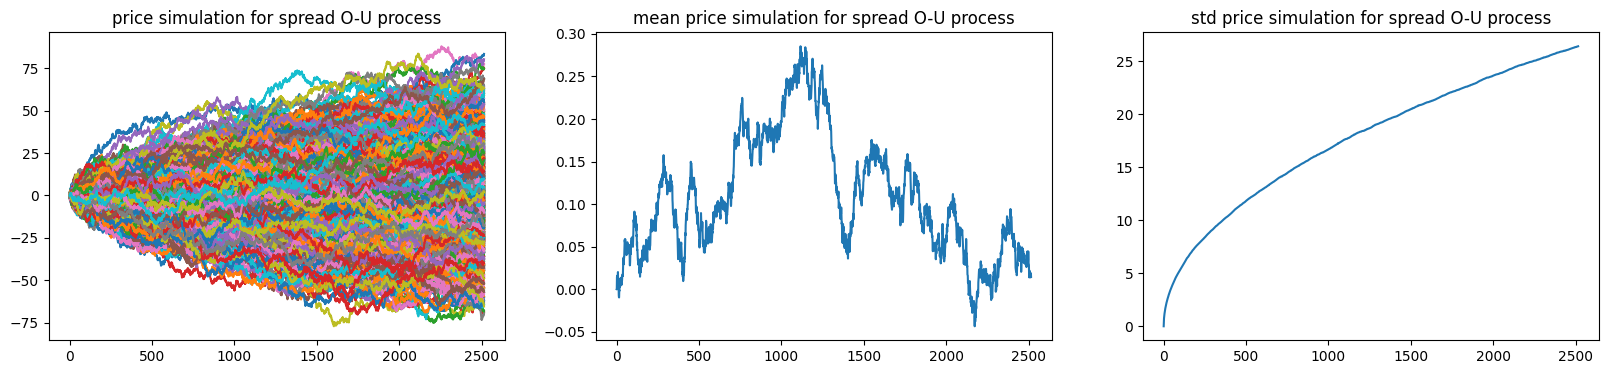

In [169]:
plot_simulations(XOU,'spread O-U process')

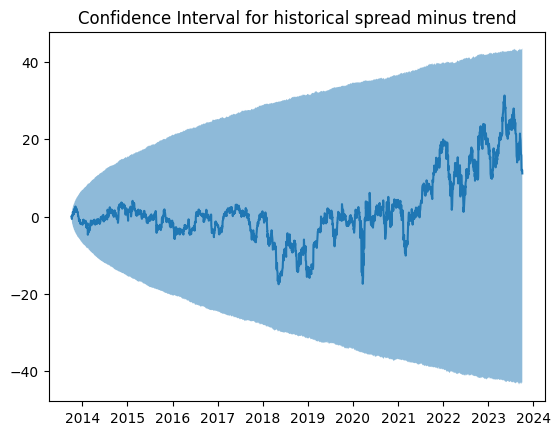

In [170]:
plt.plot(historical_spread-sTrend)
plt.fill_between(historical_spread.index,np.quantile(XOU,0.05,axis=0),np.quantile(XOU,0.95,axis=0),alpha=0.5)
plt.title('Confidence Interval for historical spread minus trend')
plt.show()

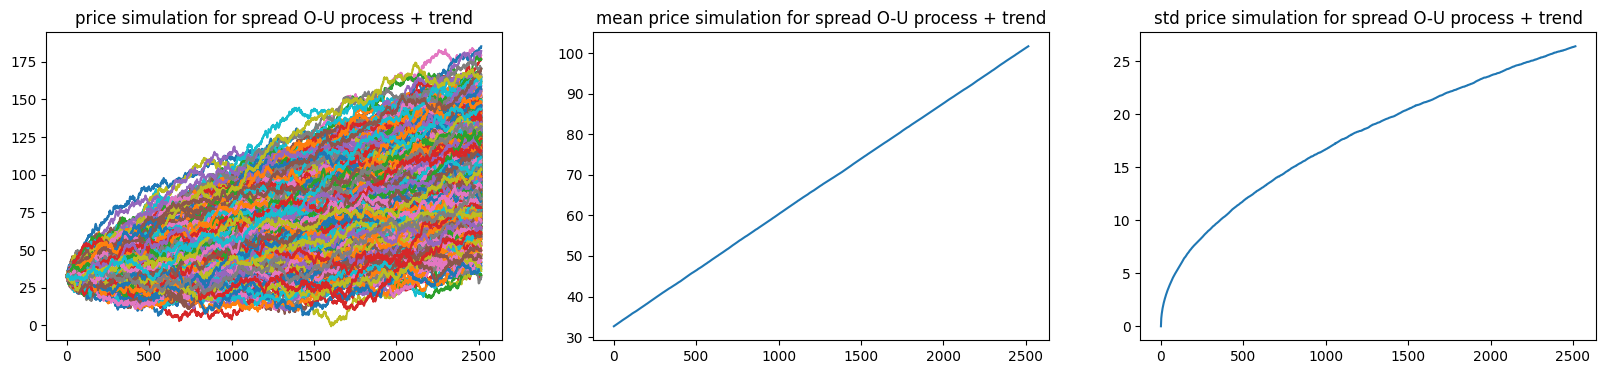

In [171]:
plot_simulations(XOU+sTrend,'spread O-U process + trend')

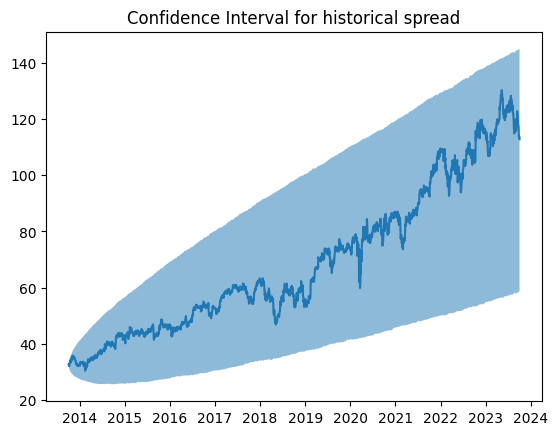

In [172]:
plt.plot(historical_spread)
plt.fill_between(historical_spread.index,np.quantile(XOU+sTrend,0.05,axis=0),np.quantile(XOU+sTrend,0.95,axis=0),alpha=0.5)
plt.title('Confidence Interval for historical spread')
plt.show()

# Extra Extra: OU Process with correlation

In [184]:
NTrials=10000

In [185]:
mu = (historical_spread - sTrend).mean()
sigma = (historical_spread - sTrend).std()
U1 = np.random.uniform(size=(NTrials, len(historical_spread)))
U2 = np.random.uniform(size=(NTrials, len(historical_spread)))
dW_1= ss.norm.ppf(U1)
dW_2= ss.norm.ppf(U2)
for i in range(NTrials):
    temp = np.stack([dW_1[i],dW_2[i]]).T @ L.T
    dW_1[i],dW_2[i] = temp[:,0],temp[:,1]
dW = dW_2-dW_1
XOU = np.zeros(dW.shape)
XOU[:, 0] = 0
a = 0.005

In [186]:
for i in range(1, len(historical_spread)):
    XOU[:, i] = XOU[:, i - 1] + a * (mu - XOU[:, i - 1]) * dt + sigma * dW[:, i] * np.sqrt(dt)

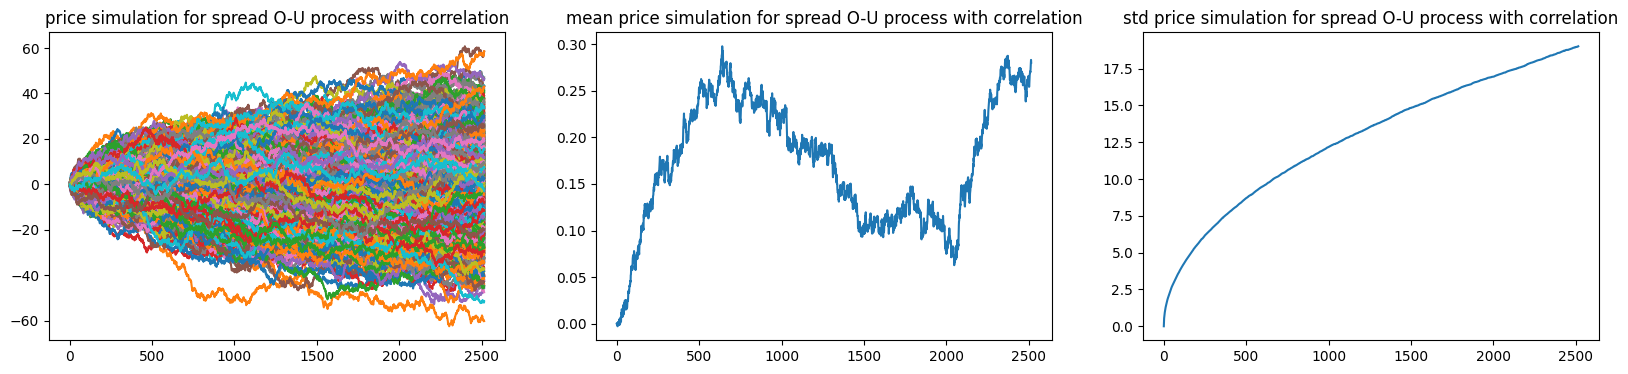

In [187]:
plot_simulations(XOU,'spread O-U process with correlation')

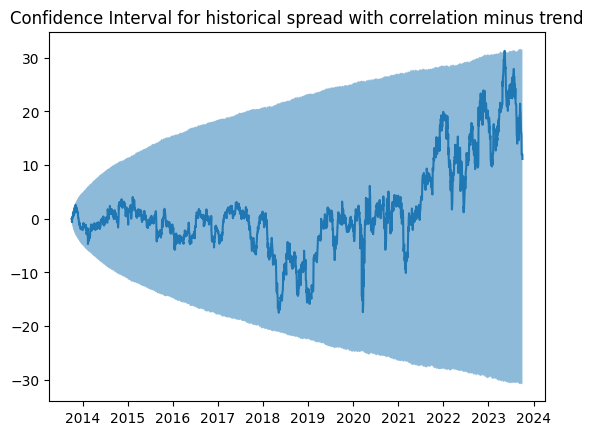

In [188]:
plt.plot(historical_spread-sTrend)
plt.fill_between(historical_spread.index,np.quantile(XOU,0.05,axis=0),np.quantile(XOU,0.95,axis=0),alpha=0.5)
plt.title('Confidence Interval for historical spread with correlation minus trend')
plt.show()

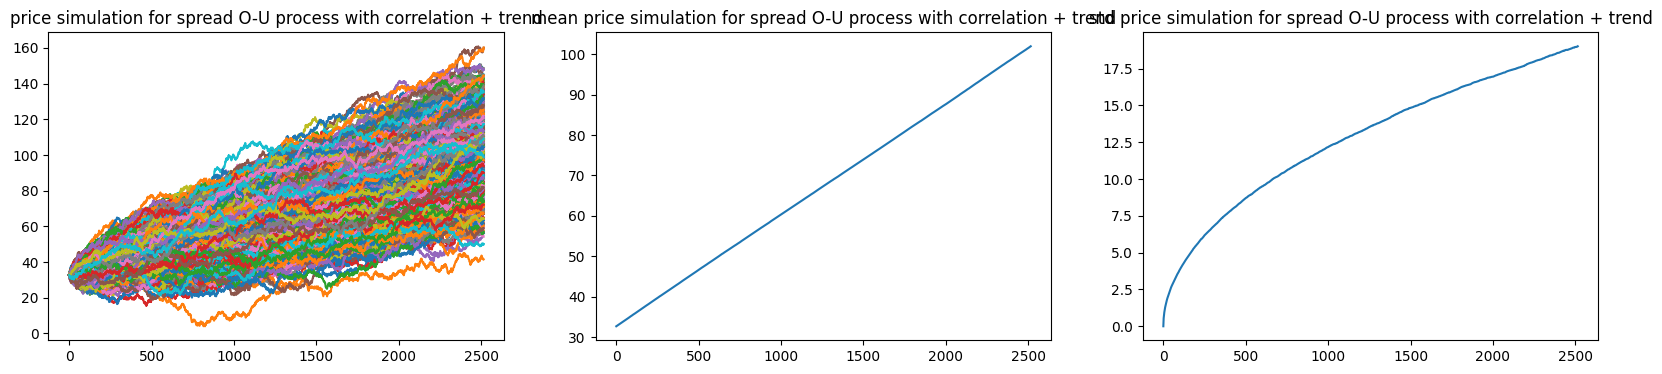

In [189]:
plot_simulations(XOU + sTrend, 'spread O-U process with correlation + trend')

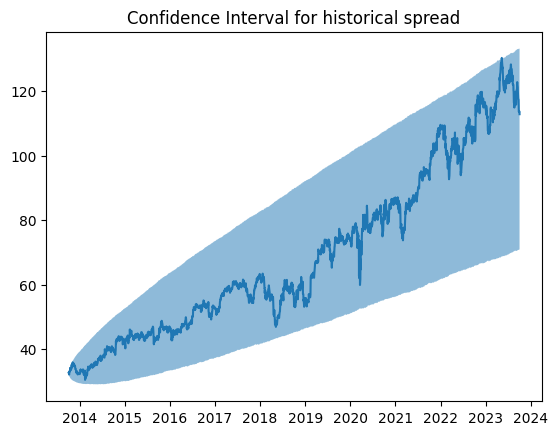

In [190]:
plt.plot(historical_spread)
plt.fill_between(historical_spread.index, np.quantile(XOU + sTrend, 0.05, axis=0),
                 np.quantile(XOU + sTrend, 0.95, axis=0), alpha=0.5)
plt.title('Confidence Interval for historical spread')
plt.show()